SINAV ÇALIŞMASIDIR

In [1]:
# KOD BLOĞU #1: Kütüphaneleri İçe Aktarma ve Veriyi Yükleme

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Makine öğrenmesi için gerekli araçlar
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve

# Kullanacağımız 3 farklı tahmin modeli
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# CSV dosyasından müşteri verilerini okuyoruz
df = pd.read_csv("data/Telco-Customer-Churn.csv")

# KOLON NUMARALAMA SİSTEMİ
def create_column_mapping(dataframe):
    "Datadaki tüm kolonları numaralandırıyorum, data değişse bile static olan bu kod çalışır."
    return {i+1: col for i, col in enumerate(dataframe.columns)}

def get_column_name(col_map, col_no):
    """Kolon numarasından kolon adını döndürür."""
    return col_map.get(col_no, None)

def get_column_number(col_map, col_name):
    """Kolon adından kolon numarasını döndürür."""
    for num, name in col_map.items():
        if name == col_name:
            return num
    return None

# İlk kolon haritasını oluştur
COLUMN_MAP = create_column_mapping(df)

# Kolon listesini yazdır
print("=" * 60)
print("KOLON NUMARALARI")
print("=" * 60)
for num, name in COLUMN_MAP.items():
    print(f"  [{num:2}] {name}")
print("=" * 60)

# İlk 5 satırı inceliyoruz
df.head()

KOLON NUMARALARI
  [ 1] customerID
  [ 2] gender
  [ 3] SeniorCitizen
  [ 4] Partner
  [ 5] Dependents
  [ 6] tenure
  [ 7] PhoneService
  [ 8] MultipleLines
  [ 9] InternetService
  [10] OnlineSecurity
  [11] OnlineBackup
  [12] DeviceProtection
  [13] TechSupport
  [14] StreamingTV
  [15] StreamingMovies
  [16] Contract
  [17] PaperlessBilling
  [18] PaymentMethod
  [19] MonthlyCharges
  [20] TotalCharges
  [21] Churn


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


VERİ SETİ ANALİZİ

Veri Boyutu: 7043 satır, 21 kolon

----------
KOLON TİP ANALİZİ
----------

 NO | KOLON ADI            | MEVCUT TİP | TAHMİN          | DURUM     
[ 1] | customerID           | object     | id              | ID (Silinecek)
[ 2] | gender               | object     | categorical     | OK
[ 3] | SeniorCitizen        | int64      | numeric_int     | OK
[ 4] | Partner              | object     | categorical     | OK
[ 5] | Dependents           | object     | categorical     | OK
[ 6] | tenure               | int64      | numeric_int     | OK
[ 7] | PhoneService         | object     | categorical     | OK
[ 8] | MultipleLines        | object     | categorical     | OK
[ 9] | InternetService      | object     | categorical     | OK
[10] | OnlineSecurity       | object     | categorical     | OK
[11] | OnlineBackup         | object     | categorical     | OK
[12] | DeviceProtection     | object     | categorical     | OK
[13] | TechSupport          | object     | categorical

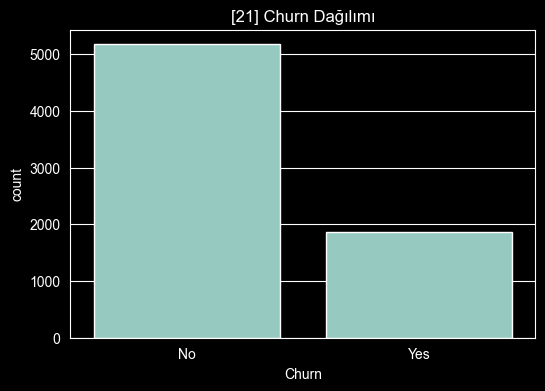

Churn
No     5174
Yes    1869
Name: count, dtype: int64
\n----------
KORELASYON ANALİZİ
----------


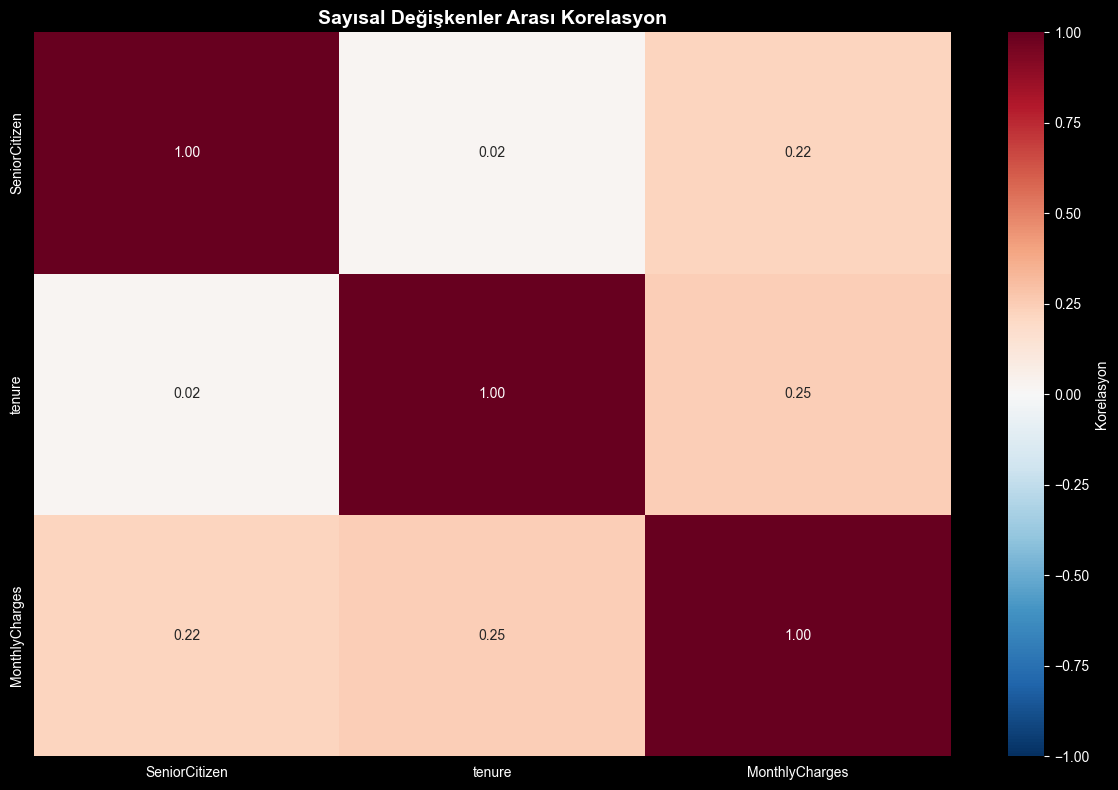

\n==========


In [2]:
# KOD BLOĞU #2: Veriyi İnceleme ve Keşfetme (KOLON NUMARALARIYLA)

print("=" * 80)
print("VERİ SETİ ANALİZİ")
print("=" * 80)

# Veri boyutu bilgisi
print(f"\nVeri Boyutu: {df.shape[0]} satır, {df.shape[1]} kolon")

# Veri tiplerini inceleme
print("\n" + "-" * 10)
print("KOLON TİP ANALİZİ")
print("-" * 10)

def infer_real_dtype(series):
    """
    Bir kolonun gerçek veri tipini tahmin eder.
    İlk 5 ve son 5 satırdaki değerlere bakarak karar verir.
    """
    sample = pd.concat([series.head(5), series.tail(5)]).dropna()

    if len(sample) == 0:
        return 'unknown'

    # Sayıya çevirmeyi dene
    try:
        numeric_sample = pd.to_numeric(sample.astype(str).str.strip(), errors='coerce')
        success_rate = numeric_sample.notna().sum() / len(sample)

        if success_rate >= 0.8:
            if (numeric_sample.dropna() % 1 == 0).all():
                return 'numeric_int'
            else:
                return 'numeric_float'
    except:
        pass

    # Kategorik mi kontrol et
    unique_count = series.nunique()
    total_count = len(series)

    if unique_count <= max(10, int(total_count * 0.05)):
        return 'categorical'

    # ID kontrolü (tüm değerler benzersiz mi?)
    if unique_count == total_count:
        return 'id'

    return 'text'

# Analiz sonuçlarını sakla
analysis_results = {}
id_columns = []
suspicious_columns = []
target_column = None

print(f"\n{'NO':>3} | {'KOLON ADI':<20} | {'MEVCUT TİP':<10} | {'TAHMİN':<15} | {'DURUM':<10}")

for col_no, col_name in COLUMN_MAP.items():
    current_dtype = str(df[col_name].dtype)
    inferred_type = infer_real_dtype(df[col_name])

    # Durumu belirle
    status = "OK"

    # ID sütunu mu?
    if inferred_type == 'id':
        status = "ID (Silinecek)"
        id_columns.append(col_name)

    # Tip uyumsuzluğu var mı?
    elif current_dtype == 'object' and inferred_type in ['numeric_int', 'numeric_float']:
        status = "UYUMSUZ"
        suspicious_columns.append(col_name)

    # Hedef sütun mu? (churn, target vb.)
    target_keywords = ['churn', 'target', 'label', 'class', 'outcome']
    if any(kw in col_name.lower() for kw in target_keywords):
        if df[col_name].nunique() == 2:
            status = "HEDEF"
            target_column = col_name

    # Sonuçları kaydet
    analysis_results[col_no] = {
        'name': col_name,
        'current_dtype': current_dtype,
        'inferred_type': inferred_type,
        'status': status
    }

    print(f"[{col_no:2}] | {col_name:<20} | {current_dtype:<10} | {inferred_type:<15} | {status}")

# Özet
print("\n" + "=" * 10)
print("ANALİZ ÖZETİ")

if id_columns:
    id_nums = [get_column_number(COLUMN_MAP, c) for c in id_columns]
    print(f"ID Kolonları (silinecek): {id_nums} → {id_columns}")

if suspicious_columns:
    susp_nums = [get_column_number(COLUMN_MAP, c) for c in suspicious_columns]
    print(f"Uyumsuz Kolonlar (düzeltilecek): {susp_nums} → {suspicious_columns}")

if target_column:
    target_num = get_column_number(COLUMN_MAP, target_column)
    print(f"Hedef Kolon: [{target_num}] → {target_column}")

# Uyumsuz kolonların detaylı incelenmesi
if suspicious_columns:
    print("\n" + "-" * 10)
    print("UYUMSUZ KOLON DETAYLARI")
    print("-" * 10)

    for col_name in suspicious_columns:
        col_no = get_column_number(COLUMN_MAP, col_name)
        print(f"\n[{col_no}] {col_name}:")
        print(f"    İlk 5 değer: {df[col_name].head(5).tolist()}")

        # Boşluk karakteri kontrolü
        blank_count = (df[col_name].astype(str).str.strip() == '').sum()
        if blank_count > 0:
            print(f"    Boş değer sayısı: {blank_count}")

# Hedef değişken grafiği
if target_column:
    print("\n" + "-" * 80)
    print(f"HEDEF DEĞİŞKEN DAĞILIMI: [{get_column_number(COLUMN_MAP, target_column)}] {target_column}")
    print("-" * 80)

    plt.figure(figsize=(6,4))
    sns.countplot(x=target_column, data=df)
    plt.title(f"[{get_column_number(COLUMN_MAP, target_column)}] {target_column} Dağılımı")
    plt.show()

    print(df[target_column].value_counts())

# Korelasyon Analizi
print("\\n" + "-" * 10)
print("KORELASYON ANALİZİ")
print("-" * 10)

# Sadece sayısal kolonları seç
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

if len(numeric_cols) >= 2:
    corr_matrix = df[numeric_cols].corr()

    # Heatmap çiz
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="RdBu_r",
                center=0, vmin=-1, vmax=1, cbar_kws={'label': 'Korelasyon'})
    plt.title("Sayısal Değişkenler Arası Korelasyon", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Hedef değişkenle en yüksek korelasyonları bul
    if target_column and target_column in corr_matrix.columns:
        target_corr = corr_matrix[target_column].abs().sort_values(ascending=False)
        print(f"\\n[{target_column}] ile en yüksek korelasyonlar:")
        for i, (col, val) in enumerate(target_corr.head(6).items()):
            if col != target_column:
                col_no = get_column_number(COLUMN_MAP, col)
                print(f"    [{col_no}] {col}: {val:.3f}")
else:
    print("Yeteri kadar sayısal kolon bulunamadı.")

print("\\n" + "=" * 10)


VERİ TEMİZLEME

[1] ID Kolonlarının Silinmesi:
----------
    [1] customerID siliniyor...
    Silinen kolon sayısı: 1

[2] Uyumsuz Kolonların Düzeltilmesi:
----------
    [19] TotalCharges: 11 eksik değer medyan (1397.47) ile dolduruldu

[3] Hedef Değişken Dönüşümü:
----------
    Hedef kolon: [20] Churn
    Mevcut değerler: ['No', 'Yes']
    Dönüşüm: {'No': 0, 'Yes': 1}

[4] Kategorik Verilerin Dönüştürülmesi (One-Hot Encoding):
----------
Kategorik kolonlar: [1, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
Kolon adları: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
One-Hot Encoding uygulandı
Yeni kolon sayısı: 31

[5] Özellik Mühendisliği:
----------
Tenure Yıl Grupları oluşturuluyor...
Oluşturuldu: NEW_TenureYear
Dağılım: {'4+_Yil': np.int64(2239), '0-1_Yil': np.int64(2186), '1-2_Yil': n

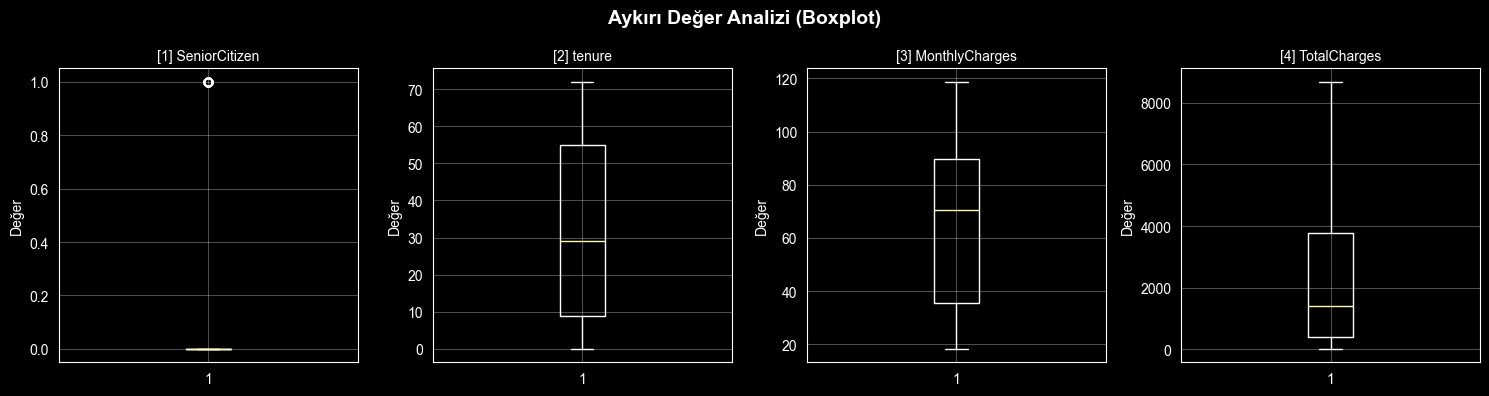


    Aykırı Değer Detayları:
    [1] SeniorCitizen:
        Alt sınır: 0.00
        Üst sınır: 0.00
        Min değer: 0.00
        Max değer: 1.00

    NOT: Aykırı değerler tespit edildi ancak silinmedi.
    Makine öğrenmesi modelleri için veri bütünlüğü korundu.

TEMİZLEME SONRASI VERİ
Boyut: 7043 satır, 36 kolon

İlk 5 kolon:
    [1] SeniorCitizen
    [2] tenure
    [3] MonthlyCharges
    [4] TotalCharges
    [5] Churn
    ... ve 31 kolon daha


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,NEW_TotalServices,NEW_TenureYear_1-2_Yil,NEW_TenureYear_2-3_Yil,NEW_TenureYear_3-4_Yil,NEW_TenureYear_4+_Yil
0,0,1,29.85,29.85,0,False,True,False,False,True,...,False,True,False,True,False,2,False,False,False,False
1,0,34,56.95,1889.50,0,True,False,False,True,False,...,False,False,False,False,True,3,False,True,False,False
2,0,2,53.85,108.15,1,True,False,False,True,False,...,False,True,False,False,True,3,False,False,False,False
3,0,45,42.30,1840.75,0,True,False,False,False,True,...,False,False,False,False,False,4,False,False,True,False
4,0,2,70.70,151.65,1,False,False,False,True,False,...,False,True,False,True,False,2,False,False,False,False


In [3]:
# KOD BLOĞU #3: Veri Temizleme ve Hazırlama (KOLON NUMARALARIYLA)

print("=" * 10)
print("VERİ TEMİZLEME")

# 1. ID KOLONLARINI SİL
print("\n[1] ID Kolonlarının Silinmesi:")
print("-" * 10)

if id_columns:
    for col_name in id_columns:
        col_no = get_column_number(COLUMN_MAP, col_name)
        print(f"    [{col_no}] {col_name} siliniyor...")
    df = df.drop(id_columns, axis=1)
    print(f"    Silinen kolon sayısı: {len(id_columns)}")
else:
    print("    ID kolonu bulunamadı")

# Kolon haritasını güncelle
COLUMN_MAP = create_column_mapping(df)

# 2. UYUMSUZ KOLONLARI DÜZELT
print("\n[2] Uyumsuz Kolonların Düzeltilmesi:")
print("-" * 10)

if suspicious_columns:
    for col_name in suspicious_columns:
        if col_name in df.columns:
            col_no = get_column_number(COLUMN_MAP, col_name)

            # Sayıya çevir
            df[col_name] = pd.to_numeric(df[col_name], errors='coerce')

            # Eksik değerleri medyan ile doldur
            missing_count = df[col_name].isna().sum()
            if missing_count > 0:
                median_val = df[col_name].median()
                df[col_name] = df[col_name].fillna(median_val)
                print(f"    [{col_no}] {col_name}: {missing_count} eksik değer medyan ({median_val:.2f}) ile dolduruldu")
            else:
                print(f"    [{col_no}] {col_name}: Sayıya çevrildi, eksik değer yok")
else:
    print("    Düzeltilecek kolon bulunamadı")

# 3. HEDEF DEĞİŞKENİ DÖNÜŞTÜR
print("\n[3] Hedef Değişken Dönüşümü:")
print("-" * 10)

if target_column and target_column in df.columns:
    target_no = get_column_number(COLUMN_MAP, target_column)
    print(f"    Hedef kolon: [{target_no}] {target_column}")
    print(f"    Mevcut değerler: {df[target_column].unique().tolist()}")

    # Eğer object tipindeyse sayıya çevir
    if df[target_column].dtype == 'object':
        unique_vals = df[target_column].unique()
        positive_keywords = ['yes', 'true', '1', 'positive', 'churn']

        target_map = {}
        for val in unique_vals:
            if str(val).lower() in positive_keywords:
                target_map[val] = 1
            else:
                target_map[val] = 0

        df[target_column] = df[target_column].map(target_map)
        print(f"    Dönüşüm: {target_map}")
    else:
        print(f"    Zaten sayısal tipte: {df[target_column].dtype}")
else:
    # Kod Bloğu #2'de hedef tespit edilmemişse, otomatik ara
    print("    Hedef kolon Kod Bloğu #2'de tespit edilmedi, otomatik arama yapılıyor...")
    target_keywords = ['churn', 'target', 'label', 'class', 'outcome', 'fraud', 'attrition', 'default']

    found = False
    for col in df.columns:
        if any(kw in col.lower() for kw in target_keywords):
            if df[col].nunique() == 2:  # Binary sınıflandırma
                target_column = col
                target_no = get_column_number(COLUMN_MAP, target_column)
                print(f"    ✓ Otomatik tespit: [{target_no}] {target_column}")

                # Dönüşüm
                if df[target_column].dtype == 'object':
                    unique_vals = df[target_column].unique()
                    positive_kw = ['yes', 'true', '1', 'positive', 'churn', 'fraud', 'default']

                    target_map = {}
                    for val in unique_vals:
                        target_map[val] = 1 if str(val).lower() in positive_kw else 0

                    df[target_column] = df[target_column].map(target_map)
                    print(f"    Dönüşüm: {target_map}")

                found = True
                break

    if not found:
        raise ValueError("❌ Hedef değişken tespit edilemedi! Lütfen manuel olarak belirtin.")

# 4. KATEGORİK VERİLERİ DÖNÜŞTÜR
print("\n[4] Kategorik Verilerin Dönüştürülmesi (One-Hot Encoding):")
print("-" * 10)

# Object tipindeki kolonları bul (hedef hariç)
categorical_cols = df.select_dtypes(include='object').columns.tolist()

if target_column in categorical_cols:
    categorical_cols.remove(target_column)

if categorical_cols:
    cat_nums = [get_column_number(COLUMN_MAP, c) for c in categorical_cols]
    print(f"Kategorik kolonlar: {cat_nums}")
    print(f"Kolon adları: {categorical_cols}")

    # One-Hot Encoding uygula
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    print(f"One-Hot Encoding uygulandı")
    print(f"Yeni kolon sayısı: {len(df.columns)}")
else:
    print("    Kategorik kolon bulunamadı")

# Kolon haritasını güncelle
COLUMN_MAP = create_column_mapping(df)

# 5. ÖZELLİK MÜHENDİSLİĞİ (Feature Engineering)
print("\n[5] Özellik Mühendisliği:")
print("-" * 10)

new_features_created = False

# Tenure varsa yıl grupları oluştur
if 'tenure' in df.columns:
    print("Tenure Yıl Grupları oluşturuluyor...")

    def tenure_to_year_group(months):
        if months <= 12: return "0-1_Yil"
        elif months <= 24: return "1-2_Yil"
        elif months <= 36: return "2-3_Yil"
        elif months <= 48: return "3-4_Yil"
        else: return "4+_Yil"

    df['NEW_TenureYear'] = df['tenure'].apply(tenure_to_year_group)
    print(f"Oluşturuldu: NEW_TenureYear")
    print(f"Dağılım: {dict(df['NEW_TenureYear'].value_counts())}")
    new_features_created = True

# Servis sayısı hesapla
service_cols = [col for col in df.columns if any(s in col.lower()
                for s in ['phone', 'internet', 'security', 'backup',
                         'protection', 'support', 'streaming'])]

if service_cols:
    print("Toplam Servis Sayısı hesaplanıyor...")
    # Her kolon için 'Yes' veya 1 içerip içermediğini kontrol et
    df['NEW_TotalServices'] = df[service_cols].apply(
        lambda row: sum(1 for val in row if str(val).lower() in ['yes', '1', 'true']),
        axis=1
    )
    print(f"Oluşturuldu: NEW_TotalServices")
    print(f"Ortalama servis: {df['NEW_TotalServices'].mean():.2f}")
    print(f"Min: {df['NEW_TotalServices'].min()}, Max: {df['NEW_TotalServices'].max()}")
    new_features_created = True

if new_features_created:
    # Yeni kategorik özellikleri encode et
    new_cat_cols = [col for col in df.columns if col.startswith('NEW_') and df[col].dtype == 'object']
    if new_cat_cols:
        df = pd.get_dummies(df, columns=new_cat_cols, drop_first=True)
        print(f"Yeni kategorik özellikler encode edildi")

    # Kolon haritasını güncelle
    COLUMN_MAP = create_column_mapping(df)
    print(f"Toplam {len([c for c in df.columns if c.startswith('NEW_')])} yeni özellik eklendi")
else:
    print("Yeni özellik oluşturulamadı (gerekli kolonlar bulunamadı)")

# 6. AYKIRI DEĞER ANALİZİ (IQR Yöntemi)
print("\n[6] Aykırı Değer Analizi (IQR Yöntemi):")
print("-" * 10)

# Sayısal kolonları bul
numeric_cols_for_outlier = df.select_dtypes(include=[np.number]).columns.tolist()

# Hedef değişkeni çıkar
if target_column and target_column in numeric_cols_for_outlier:
    numeric_cols_for_outlier.remove(target_column)

outlier_info = {}

for col in numeric_cols_for_outlier:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers_mask = (df[col] < lower_bound) | (df[col] > upper_bound)
    outliers_count = outliers_mask.sum()

    if outliers_count > 0:
        outlier_ratio = outliers_count / len(df) * 100
        col_no = get_column_number(COLUMN_MAP, col)
        outlier_info[col] = {
            'count': outliers_count,
            'ratio': outlier_ratio,
            'lower': lower_bound,
            'upper': upper_bound
        }
        print(f"    [{col_no}] {col}: {outliers_count} aykırı değer ({outlier_ratio:.1f}%)")

if not outlier_info:
    print("Aykırı değer tespit edilmedi")

# Görselleştirme: Boxplot
if numeric_cols_for_outlier:
    print("\n    Boxplot görselleştirmesi oluşturuluyor...")
    n_cols_to_plot = min(4, len(numeric_cols_for_outlier))

    fig, axes = plt.subplots(1, n_cols_to_plot, figsize=(15, 4))
    if n_cols_to_plot == 1:
        axes = [axes]

    for i, col in enumerate(numeric_cols_for_outlier[:n_cols_to_plot]):
        axes[i].boxplot(df[col].dropna(), vert=True)
        col_no = get_column_number(COLUMN_MAP, col)
        axes[i].set_title(f'[{col_no}] {col}', fontsize=10)
        axes[i].set_ylabel('Değer')
        axes[i].grid(True, alpha=0.3)

    plt.suptitle("Aykırı Değer Analizi (Boxplot)", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Ek bilgi: Aykırı değerlerin detayları
    if outlier_info:
        print("\n    Aykırı Değer Detayları:")
        for col, info in outlier_info.items():
            col_no = get_column_number(COLUMN_MAP, col)
            print(f"    [{col_no}] {col}:")
            print(f"        Alt sınır: {info['lower']:.2f}")
            print(f"        Üst sınır: {info['upper']:.2f}")
            print(f"        Min değer: {df[col].min():.2f}")
            print(f"        Max değer: {df[col].max():.2f}")

print("\n    NOT: Aykırı değerler tespit edildi ancak silinmedi.")
print("    Makine öğrenmesi modelleri için veri bütünlüğü korundu.")

# Son durum
print("\n" + "=" * 10)
print("TEMİZLEME SONRASI VERİ")
print(f"Boyut: {df.shape[0]} satır, {df.shape[1]} kolon")
print(f"\nİlk 5 kolon:")
for i, (num, name) in enumerate(COLUMN_MAP.items()):
    if i >= 5:
        print(f"    ... ve {len(COLUMN_MAP) - 5} kolon daha")
        break
    print(f"    [{num}] {name}")

df.head()

In [4]:
# KOD BLOĞU #4: Veriyi Eğitim ve Test Olarak Ayırma (KOLON NUMARALARIYLA)

print("=" * 10)
print("VERİ BÖLME VE ÖLÇEKLENDİRME")
print("=" * 10)

# 1. HEDEF KOLONU BUL
print("\n[1] Hedef Kolon:")
print("-" * 10)

# target_column değişkeni Kod Bloğu #2'den geliyor
if target_column and target_column in df.columns:
    target_no = get_column_number(COLUMN_MAP, target_column)
    print(f"    Hedef: [{target_no}] {target_column}")
else:
    # Hedef kolon zaten Kod Bloğu #3'de bulunmuş olmalı
    raise ValueError("❌ Hedef değişken bulunamadı! Kod Bloğu #3'ü kontrol edin.")

# 2. X VE Y AYIR
print("\n[2] Özellik (X) ve Hedef (y) Ayrımı:")
print("-" * 10)

y = df[target_column]
X = df.drop(target_column, axis=1)

print(f"    Hedef (y): [{target_no}] {target_column}")
print(f"    Özellik (X): {X.shape[1]} kolon")
print(f"    Hedef dağılımı: 0 → {(y == 0).sum()}, 1 → {(y == 1).sum()}")

# 3. DENGESİZLİK KONTROLÜ
print("\n[3] Dengesizlik Kontrolü:")
print("-" * 10)

class_ratio = y.value_counts(normalize=True)
minority_ratio = class_ratio.min()

if minority_ratio < 0.3:
    print(f"    Dengesiz veri tespit edildi!")
    print(f"    Azınlık sınıf oranı: {minority_ratio:.1%}")
    print(f"    stratify=y kullanılacak")
else:
    print(f"    Veri dengeli (azınlık oranı: {minority_ratio:.1%})")

# 4. EĞİTİM/TEST BÖLME
print("\n[4] Eğitim/Test Bölme:")
print("-" * 40)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"    Eğitim seti: {len(X_train)} satır (%80)")
print(f"    Test seti: {len(X_test)} satır (%20)")

# 5. ÖLÇEKLENDİRME
print("\n[5] Özellik Ölçeklendirme (StandardScaler):")
print("-" * 40)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"    Tüm özellikler ölçeklendirildi")
print(f"    Ortalama: 0, Standart Sapma: 1")

print("\n" + "=" * 10)

VERİ BÖLME VE ÖLÇEKLENDİRME

[1] Hedef Kolon:
----------
    Hedef: [5] Churn

[2] Özellik (X) ve Hedef (y) Ayrımı:
----------
    Hedef (y): [5] Churn
    Özellik (X): 35 kolon
    Hedef dağılımı: 0 → 5174, 1 → 1869

[3] Dengesizlik Kontrolü:
----------
    Dengesiz veri tespit edildi!
    Azınlık sınıf oranı: 26.5%
    stratify=y kullanılacak

[4] Eğitim/Test Bölme:
----------------------------------------
    Eğitim seti: 5634 satır (%80)
    Test seti: 1409 satır (%20)

[5] Özellik Ölçeklendirme (StandardScaler):
----------------------------------------
    Tüm özellikler ölçeklendirildi
    Ortalama: 0, Standart Sapma: 1



MODEL 1: LOGISTIC REGRESSION

Accuracy: 0.8027 (80.27%)

Detaylı Rapor:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.66      0.53      0.59       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.73      1409
weighted avg       0.79      0.80      0.80      1409



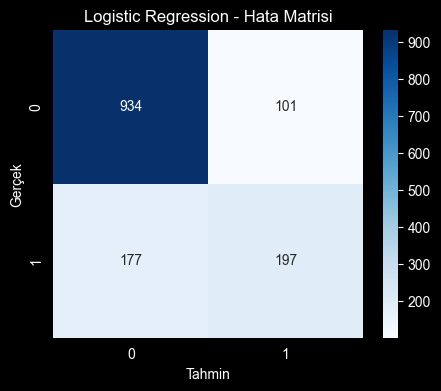

In [5]:
# KOD BLOĞU #5: Model 1 - Logistic Regression
# En basit sınıflandırma modeli
# Her özelliğe ağırlık verir, ağırlıklı toplam 0.5'ten büyükse → Churn=1

print("=" * 10)
print("MODEL 1: LOGISTIC REGRESSION")

# Modeli oluştur ve eğit
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

# Tahmin yap
y_pred_log = log_model.predict(X_test)

# Sonuçları kaydet
log_accuracy = accuracy_score(y_test, y_pred_log)

print(f"\nAccuracy: {log_accuracy:.4f} ({log_accuracy*100:.2f}%)")
print("\nDetaylı Rapor:")
print(classification_report(y_test, y_pred_log))

# Hata Matrisi
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_log), annot=True, fmt='d', cmap='Blues')
plt.title("Logistic Regression - Hata Matrisi")
plt.ylabel('Gerçek')
plt.xlabel('Tahmin')
plt.show()

MODEL 2: RANDOM FOREST

Accuracy: 0.7793 (77.93%)

Detaylı Rapor:
              precision    recall  f1-score   support

           0       0.82      0.89      0.86      1035
           1       0.61      0.47      0.53       374

    accuracy                           0.78      1409
   macro avg       0.72      0.68      0.69      1409
weighted avg       0.77      0.78      0.77      1409



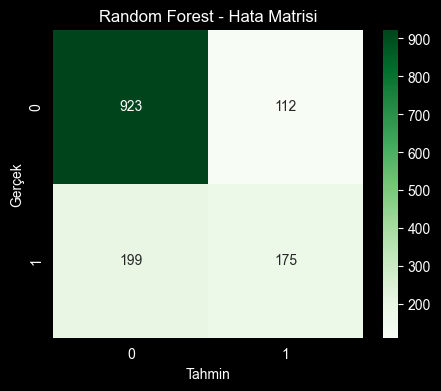

In [6]:
# KOD BLOĞU #6: Model 2 - Random Forest
# Birden fazla karar ağacı oluşturur (100 ağaç)
# Tüm ağaçlar oy kullanır, çoğunluk kazanır

print("=" * 10)
print("MODEL 2: RANDOM FOREST")

# Modeli oluştur ve eğit
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Tahmin yap
y_pred_rf = rf_model.predict(X_test)

# Sonuçları kaydet
rf_accuracy = accuracy_score(y_test, y_pred_rf)

print(f"\nAccuracy: {rf_accuracy:.4f} ({rf_accuracy*100:.2f}%)")
print("\nDetaylı Rapor:")
print(classification_report(y_test, y_pred_rf))

# Hata Matrisi
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Greens')
plt.title("Random Forest - Hata Matrisi")
plt.ylabel('Gerçek')
plt.xlabel('Tahmin')
plt.show()

MODEL 3: XGBOOST

Accuracy: 0.7800 (78.00%)

Detaylı Rapor:
              precision    recall  f1-score   support

           0       0.83      0.88      0.85      1035
           1       0.60      0.51      0.55       374

    accuracy                           0.78      1409
   macro avg       0.72      0.69      0.70      1409
weighted avg       0.77      0.78      0.77      1409



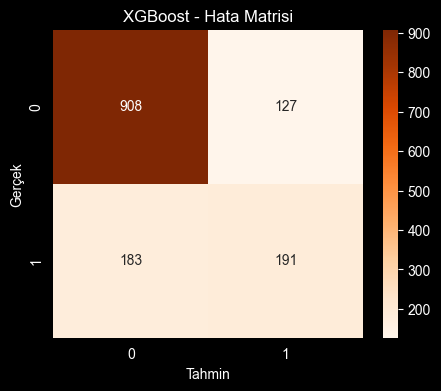

In [7]:
# KOD BLOĞU #7: Model 3 - XGBoost
# Gradient boosting tekniği kullanır
# Her yeni ağaç, önceki ağacın hatalarını düzeltmeye çalışır

print("=" * 10)
print("MODEL 3: XGBOOST")
print("=" * 10)

# Modeli oluştur ve eğit
# logloss: Modelin tahminlerindeki güveni de ölçer
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Tahmin yap
y_pred_xgb = xgb_model.predict(X_test)

# Sonuçları kaydet
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)

print(f"\nAccuracy: {xgb_accuracy:.4f} ({xgb_accuracy*100:.2f}%)")
print("\nDetaylı Rapor:")
print(classification_report(y_test, y_pred_xgb))

# Hata Matrisi
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Oranges')
plt.title("XGBoost - Hata Matrisi")
plt.ylabel('Gerçek')
plt.xlabel('Tahmin')
plt.show()

GELİŞMİŞ MODEL KARŞILAŞTIRMA

DETAYLI PERFORMANS TABLOSU:
----------
              Model  Accuracy  F1 Score   Recall  Precision
Logistic Regression  0.802697  0.586310 0.526738   0.661074
      Random Forest  0.779276  0.529501 0.467914   0.609756
            XGBoost  0.779986  0.552023 0.510695   0.600629

🏆 EN İYİ MODEL: Logistic Regression
   Accuracy:  0.8027 (80.27%)
   F1 Score:  0.5863 (Precision ve Recall dengesi)
   Recall:    0.5267 (Churn'leri yakalama oranı)


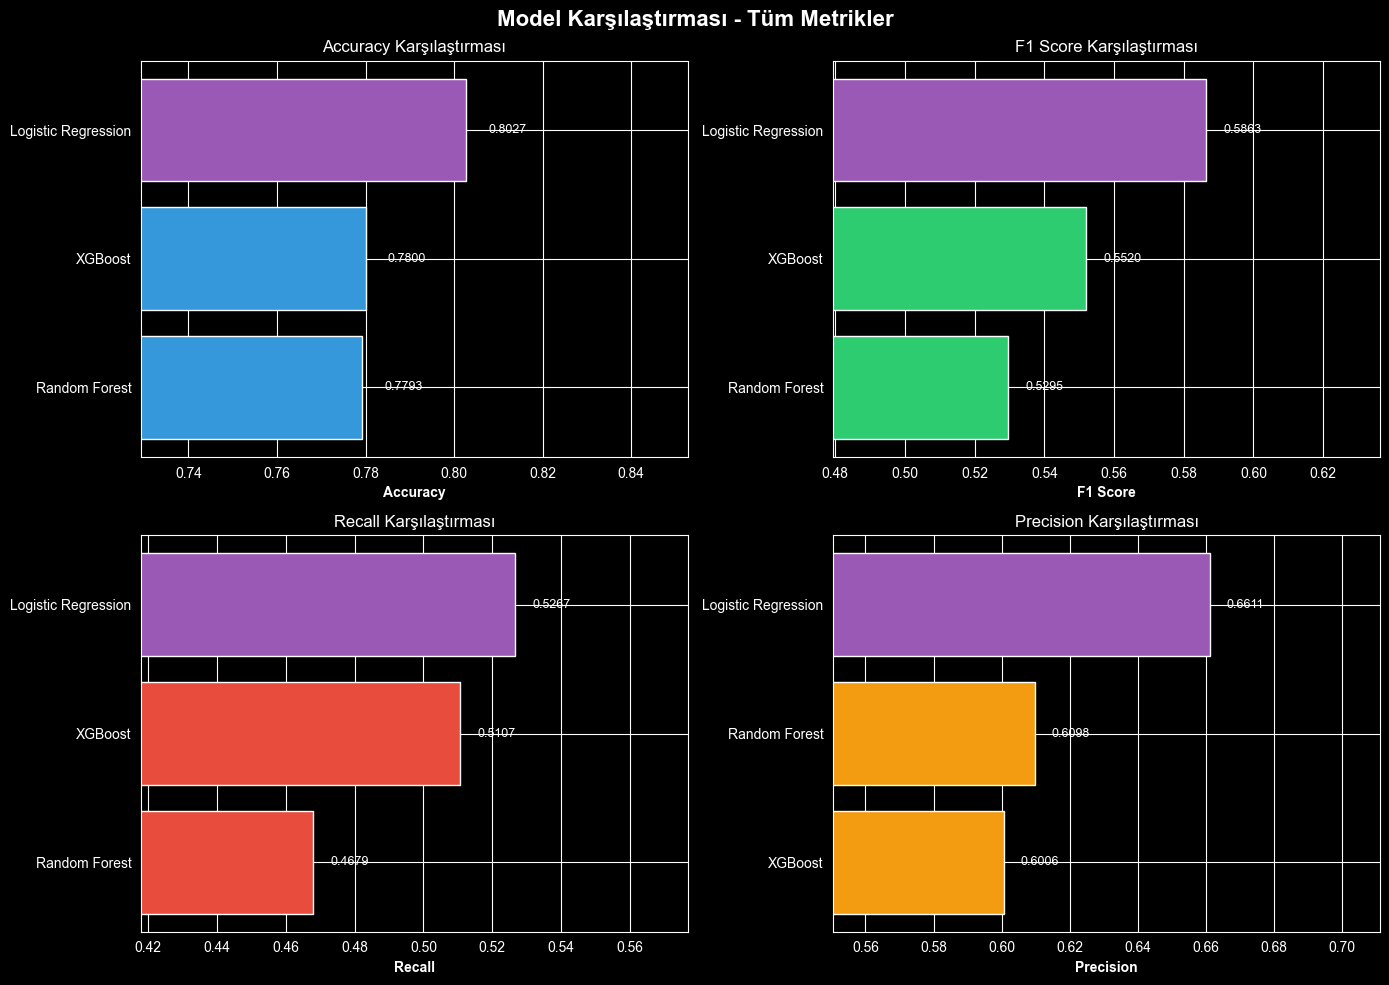


SONUÇ:
Bu veri seti için Logistic Regression modeli en iyi performansı gösterdi.
Model, test verisinde 80.27% doğruluk ve 0.5863 F1 Score'a ulaştı.
Recall: 0.5267 - Model churn olacak müşterilerin %52.7'ini yakalayabiliyor.


In [8]:
# KOD BLOĞU #8: Model Karşılaştırma ve Sonuç
print("=" * 10)
print("GELİŞMİŞ MODEL KARŞILAŞTIRMA")
print("=" * 10)

# Tüm metrikleri hesapla
results = {
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Accuracy': [
        log_accuracy,
        rf_accuracy,
        xgb_accuracy
    ],
    'F1 Score': [
        f1_score(y_test, y_pred_log),
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_xgb)
    ],
    'Recall': [
        recall_score(y_test, y_pred_log),
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_xgb)
    ],
    'Precision': [
        precision_score(y_test, y_pred_log),
        precision_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_xgb)
    ]
}

results_df = pd.DataFrame(results)

print("\nDETAYLI PERFORMANS TABLOSU:")
print("-" * 10)
print(results_df.to_string(index=False))

# En iyi modeli F1 Score'a göre seç (daha dengeli metrik)
best_idx = results_df['F1 Score'].idxmax()
best_model_name = results_df.iloc[best_idx]['Model']
best_f1 = results_df.iloc[best_idx]['F1 Score']
best_accuracy = results_df.iloc[best_idx]['Accuracy']
best_recall = results_df.iloc[best_idx]['Recall']

print("\n" + "=" * 10)
print(f"🏆 EN İYİ MODEL: {best_model_name}")
print(f"   Accuracy:  {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")
print(f"   F1 Score:  {best_f1:.4f} (Precision ve Recall dengesi)")
print(f"   Recall:    {best_recall:.4f} (Churn'leri yakalama oranı)")
print("=" * 10)

# Görsel karşılaştırma - Tüm metrikler
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Model Karşılaştırması - Tüm Metrikler', fontsize=16, fontweight='bold')

metrics = ['Accuracy', 'F1 Score', 'Recall', 'Precision']
colors_palette = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']

for idx, (ax, metric) in enumerate(zip(axes.flat, metrics)):
    sorted_df = results_df.sort_values(metric, ascending=True)
    colors = [colors_palette[idx] if m != best_model_name else '#9b59b6' for m in sorted_df['Model']]

    bars = ax.barh(sorted_df['Model'], sorted_df[metric], color=colors)
    ax.set_xlabel(metric, fontweight='bold')
    ax.set_title(f'{metric} Karşılaştırması')

    # Değerleri göster
    for bar, val in zip(bars, sorted_df[metric]):
        ax.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
                f'{val:.4f}', va='center', fontsize=9)

    # X ekseni sınırlarını ayarla
    min_val = sorted_df[metric].min()
    max_val = sorted_df[metric].max()
    ax.set_xlim(min_val - 0.05, max_val + 0.05)

plt.tight_layout()
plt.show()

print("\nSONUÇ:")
print(f"Bu veri seti için {best_model_name} modeli en iyi performansı gösterdi.")
print(f"Model, test verisinde {best_accuracy*100:.2f}% doğruluk ve {best_f1:.4f} F1 Score'a ulaştı.")
print(f"Recall: {best_recall:.4f} - Model churn olacak müşterilerin %{best_recall*100:.1f}'ini yakalayabiliyor.")


In [9]:
# KOD BLOĞU #9: Cross-Validation (Çapraz Doğrulama)

print("=" * 10)
print("CROSS-VALIDATION (ÇAPRAZ DOĞRULAMA)")
print("=" * 10)

print("\n5 katlı çapraz doğrulama yapılıyor...")
print("-" * 10)

# Her model için CV skorları
cv_results = {}

# Logistic Regression CV
log_cv = cross_val_score(LogisticRegression(max_iter=1000, random_state=42),
                         X_train, y_train, cv=5, scoring='f1')
cv_results['Logistic Regression'] = log_cv
print(f"Logistic Regression: {log_cv.mean():.4f} (+/- {log_cv.std():.4f})")

# Random Forest CV
rf_cv = cross_val_score(RandomForestClassifier(n_estimators=100, random_state=42),
                        X_train, y_train, cv=5, scoring='f1')
cv_results['Random Forest'] = rf_cv
print(f"Random Forest:       {rf_cv.mean():.4f} (+/- {rf_cv.std():.4f})")

# XGBoost CV
xgb_cv = cross_val_score(XGBClassifier(eval_metric='logloss', random_state=42),
                         X_train, y_train, cv=5, scoring='f1')
cv_results['XGBoost'] = xgb_cv
print(f"XGBoost:             {xgb_cv.mean():.4f} (+/- {xgb_cv.std():.4f})")

# En kararlı model
std_scores = {k: v.std() for k, v in cv_results.items()}
most_stable = min(std_scores, key=std_scores.get)
print(f"\n✓ En kararlı model: {most_stable} (std: {std_scores[most_stable]:.4f})")


CROSS-VALIDATION (ÇAPRAZ DOĞRULAMA)

5 katlı çapraz doğrulama yapılıyor...
----------
Logistic Regression: 0.5950 (+/- 0.0192)
Random Forest:       0.5437 (+/- 0.0236)
XGBoost:             0.5539 (+/- 0.0295)

✓ En kararlı model: Logistic Regression (std: 0.0192)


In [10]:
# KOD BLOĞU #10: Hiperparametre Optimizasyonu (GridSearchCV)
print("=" * 10)
print("HİPERPARAMETRE OPTİMİZASYONU")
print("=" * 10)

# XGBoost için basit GridSearch
print("\nXGBoost için GridSearchCV...")
print("-" * 10)

param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100],
    'learning_rate': [0.1, 0.2]
}

grid_search = GridSearchCV(
    XGBClassifier(eval_metric='logloss', random_state=42),
    param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print(f"En iyi parametreler: {grid_search.best_params_}")
print(f"En iyi CV F1 skoru:  {grid_search.best_score_:.4f}")

# Optimize edilmiş model ile tahmin
y_pred_optimized = grid_search.best_estimator_.predict(X_test)
optimized_f1 = f1_score(y_test, y_pred_optimized)
print(f"Test F1 skoru:       {optimized_f1:.4f}")

# Karşılaştırma
improvement = (optimized_f1 - f1_score(y_test, y_pred_xgb)) * 100
print(f"\n✓ İyileştirme: {improvement:+.2f}% F1 artışı")


HİPERPARAMETRE OPTİMİZASYONU

XGBoost için GridSearchCV...
----------
En iyi parametreler: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
En iyi CV F1 skoru:  0.5926
Test F1 skoru:       0.5684

✓ İyileştirme: +1.64% F1 artışı


FEATURE IMPORTANCE (ÖZELLİK ÖNEMİ)

En önemli 10 özellik:
----------
[  4] TotalCharges                   | 0.1657
[  3] MonthlyCharges                 | 0.1540
[  2] tenure                         | 0.1521
[ 32] NEW_TotalServices              | 0.0471
[ 30] PaymentMethod_Electronic check | 0.0417
[ 12] InternetService_Fiber optic    | 0.0350
[ 27] Contract_Two year              | 0.0309
[ 28] PaperlessBilling_Yes           | 0.0268
[  6] gender_Male                    | 0.0267
[  7] Partner_Yes                    | 0.0229


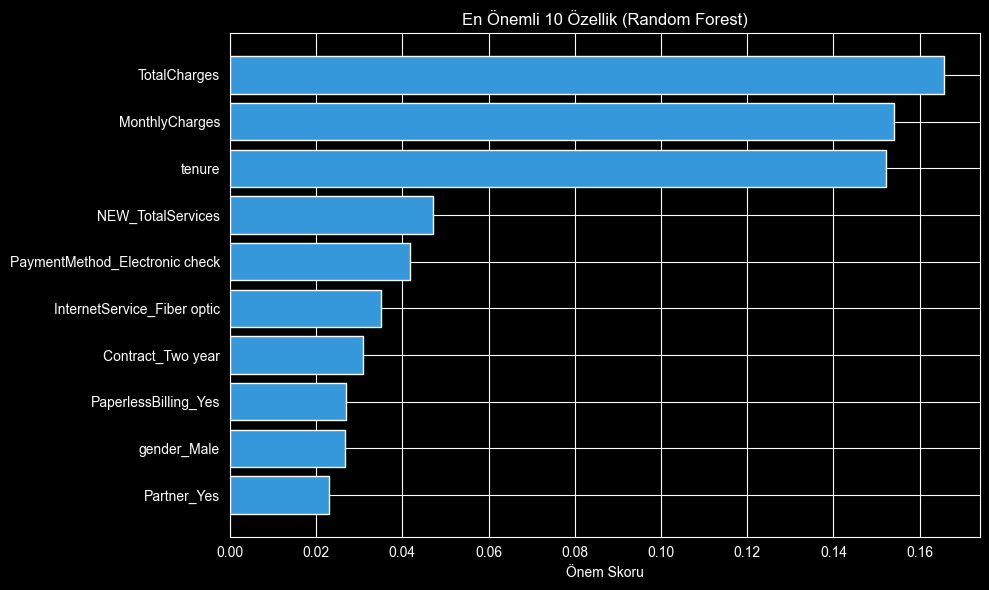

In [11]:
# KOD BLOĞU #11: Feature Importance (Özellik Önemi)
print("=" * 10)
print("FEATURE IMPORTANCE (ÖZELLİK ÖNEMİ)")
print("=" * 10)

# Random Forest'tan özellik önemlerini al
feature_importance = pd.DataFrame({
    'Özellik': X.columns,
    'Önem': rf_model.feature_importances_
}).sort_values('Önem', ascending=False)

# En önemli 10 özellik
print("\nEn önemli 10 özellik:")
print("-" * 10)
for i, row in feature_importance.head(10).iterrows():
    col_no = get_column_number(COLUMN_MAP, row['Özellik']) or '-'
    print(f"[{col_no:>3}] {row['Özellik']:<30} | {row['Önem']:.4f}")

# Görselleştirme
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(10)
plt.barh(top_features['Özellik'], top_features['Önem'], color='#3498db')
plt.xlabel('Önem Skoru')
plt.title('En Önemli 10 Özellik (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


ROC-AUC ANALİZİ

ROC-AUC Skorları:
----------
Logistic Regression: 0.8420
Random Forest:       0.8235
XGBoost:             0.8198


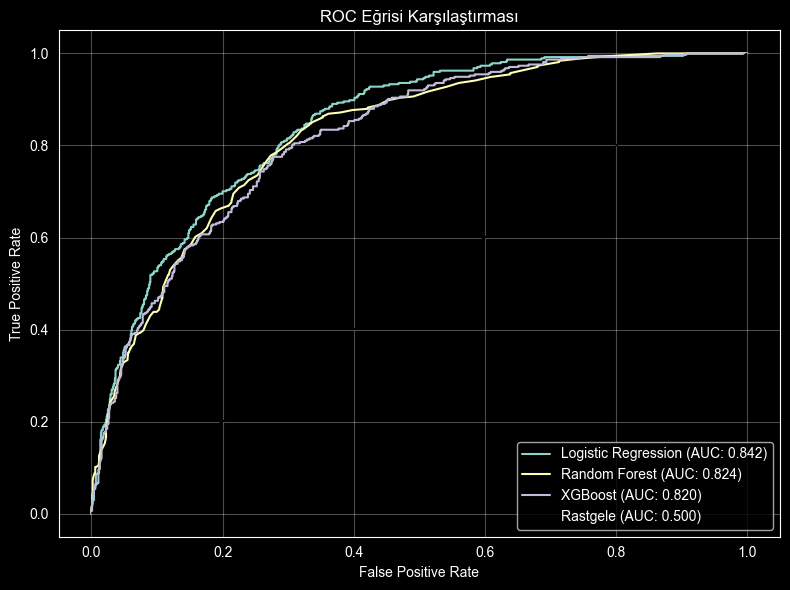


✓ En yüksek AUC: Logistic Regression (0.8420)


In [12]:
# KOD BLOĞU #12: ROC-AUC Analizi
print("=" * 10)
print("ROC-AUC ANALİZİ")
print("=" * 10)

# Her model için olasılık tahminleri
y_prob_log = log_model.predict_proba(X_test)[:, 1]
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

# AUC skorları
auc_log = roc_auc_score(y_test, y_prob_log)
auc_rf = roc_auc_score(y_test, y_prob_rf)
auc_xgb = roc_auc_score(y_test, y_prob_xgb)

print("\nROC-AUC Skorları:")
print("-" * 10)
print(f"Logistic Regression: {auc_log:.4f}")
print(f"Random Forest:       {auc_rf:.4f}")
print(f"XGBoost:             {auc_xgb:.4f}")

# ROC eğrisi çizimi
plt.figure(figsize=(8, 6))

for name, y_prob, auc in [('Logistic Regression', y_prob_log, auc_log),
                           ('Random Forest', y_prob_rf, auc_rf),
                           ('XGBoost', y_prob_xgb, auc_xgb)]:
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC: {auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Rastgele (AUC: 0.500)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Eğrisi Karşılaştırması')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# En iyi AUC
best_auc_model = max([('Logistic Regression', auc_log),
                      ('Random Forest', auc_rf),
                      ('XGBoost', auc_xgb)], key=lambda x: x[1])
print(f"\n✓ En yüksek AUC: {best_auc_model[0]} ({best_auc_model[1]:.4f})")

